<div style="display: flex; align-items: center; padding: 20px;">
    <div style="flex-grow: 1;">
        <h2><strong>MOSHFEGHI Maxime - PHUNG Anh Minh</strong></h2>
    </div>
    <div style="flex-shrink: 0; width: 40%;">
        <img src="https://hal.insa-toulouse.fr/public/Logo_INSAToulouse_blanc.png" alt="Logo INSA Toulouse" style="width: 90%; height: auto;">
    </div>
</div>

# **<div align = "center"> TP 2: Image segmentation with Neural Network </div>**

## **Objective:**
- Introduction to Pytorch (see previous tutorial notebook)
- Define a simple neural network
- Define a training procedure
- Compare difference optimization methods
- Enhance your coding skills

We consider an image as a function from $\Omega$ to $\mathbb{R}$, where $\Omega$ is a discretization of the space $[0,1]^2$. In this notebook, we suppose that we can partition $\Omega$ into $2$ regular domains $\Omega_1$ and $\Omega_2 = \Omega /  \Omega_1$.

On each domain, we suppose that the image has different textures. We will generate these textures as stationary Gaussian processes:
- We will first generate a Gaussian noise. 
- We will then convolve this noise with a filter which describes the covariance matrix of the process. 



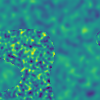
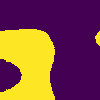


Above is an example of an image and its partition $\Omega_1$ and $\Omega_2$. The objective is from the image on the left, train a neural network to predict the mask on the right.

La dataset que l'on va étudier aura la structure suivante :

$$
(\text{image}_i, \Omega_1^i)_i
$$

Nous allons entraîner un modèle :

$$
f_\theta(\text{image}) = \Omega_1
$$
en minimisant :
$$
\min_\theta \mathbb{E}\displaystyle\left[ l\left( f_\theta(\text{image}), \Omega_1 \right) \right]
$$
où $l$ est la fonction perte (loss).

$$
f_\theta(\text{image}) \simeq \mathbb{P}(\text{"appartenir à } \Omega_1 \text{ pour chaque pixel"}) 
$$

Les images seront générés grâce à des gaussiennes qui permettront de créer une image de base, puis une partie floue dans l'image. On rapelle la fonction de répartition d'une gaussienne à 2 dimensions :

$$
g(x,y) = \cfrac{1}{2\pi \sigma^2}\exp\displaystyle\left(-\cfrac{x^2 + y^2}{2 \sigma^2}\right)
$$

In [ ]:
import matplotlib.pyplot as plt                 # Importation de la bibliothèque matplotlib pour tracer des graphiques
import torch                                    # Importation de la bibliothèque torch pour le calcul tensoriel                            
import torch.optim as optim                     # Importation de la bibliothèque torch.optim pour les optimiseurs
import torch.nn as nn                           # Importation de la bibliothèque torch.nn pour les réseaux de neurones    
import torch.nn.functional as F                 # Importation de la bibliothèque torch.nn.functional pour les fonctions de coût
import numpy as np                              # Importation de la bibliothèque numpy pour la manipulation de vecteurs et matrices
from torch.optim import SGD, Adam, RMSprop      # Importation des optimiseurs SGD, Adam et RMSprop

Define your device and data type

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')       # Utilisation du GPU si disponible, sinon CPU
dtype = torch.float32                                                       # Utilisation de flottants 32-bit
factory_kwargs = {'device': device, 'dtype': dtype}                         # Dictionnaire des paramètres pour le type de données et le type de processeur

print("factory_kwargs: ", factory_kwargs)                                # Affichage des paramètres     

In [ ]:
torch.manual_seed(42)                                    # Initialisation du générateur aléatoire pour la reproductibilité des résultats 

### **Generating data**

The following function will generate a batch of data with shape `(batch_size, 1, image_size, image_size)`
Take a look at this function and try to understand what it does. 

In [ ]:
def generate_data(batch_size: int,                                 # Fonction pour générer des données           
                  image_size: int = 128,                            # Taille de l'image
                  sigma1: float = 1.,                               # Ecart type du premier processus Gaussien
                  sigma2: float = 0.2,                              # Ecart type du second processus Gaussien
                  sigma: float = 100,                               # Ecart type du processus Gaussien de l'image
                  **factory_kwargs) -> torch.Tensor:                # Paramètres pour le type de données et le type de processeur
    
    # Defining a grid directly on device, without the need of calling `.to(device)` method,
    # which is time consuming.
    xs = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)      # Définition d'une grille sur l'axe des abscisses 
    ys = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)      # Définition d'une grille sur l'axe des ordonnées

    # The type of x,y below is automatically in device and dtype of x, y.
    x, y = torch.meshgrid(xs, ys, indexing='xy')                                     # Définition d'une grille 2D
    
    # Defining 4 Gaussian
    g = torch.exp(-(x**2 + y**2) / (2 * sigma**2))                                      # Définition d'une gaussienne  
    g = g / torch.sum(g)                                                            # Normalisation de la gaussienne            
    
    g1 = torch.exp(-(x**2 + y**2) / (2 * sigma1**2))                                # Définition d'une gaussienne 
    g1 = g1 / torch.sum(g1)                                                         # Normalisation de la gaussienne      

    g2 = torch.exp(-(x**2 + y**2) / (2 * sigma2**2))                                # Définition d'une gaussienne
    g2 = g2 / torch.sum(g2)                                                         # Normalisation de la gaussienne

    g3 = torch.exp(-(x**2 + y**2) / (2 * 1**2))                                     # Définition d'une gaussienne
    g3 = g3 / torch.sum(g3)                                                         # Normalisation de la gaussienne 
    
    # We define a random smooth partition
    b = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)           # Définition d'un tenseur de nombres aléatoires 
    gp = F.conv2d(b, g[None,None], padding = 'same')  # Convolution                 # Définition d'un tenseur de nombres aléatoires convolué avec la gaussienne

    omega_1 = gp > 0                                                # Définition d'une partition aléatoire 
    omega_2 = ~omega_1                                              # Définition d'une partition aléatoire
    
    # We define two Gaussian random processes with different statistics
    b1 = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)          # Définition d'un tenseur de nombres aléatoires
    gp1 = F.conv2d(b1, g1[None,None], padding = 'same')                             # Définition d'un tenseur de nombres aléatoires convolué avec la gaussienne
    
    b2 = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)          # Définition d'un tenseur de nombres aléatoires
    gp2 = F.conv2d(b2, g2[None,None], padding = 'same')                             # Définition d'un tenseur de nombres aléatoires convolué avec la gaussienne
    
    # Now we put each process at the right place
    image = gp1 * omega_1 + gp2 * omega_2                                           # Définition d'une image
    # We smooth the result to avoid having a jump at the interfaces of the partition
    image =  F.conv2d(image, g3[None,None], padding = 'same')                       # Définition d'une image convoluée avec la gaussienne

    # We normalize the image in to [0,1]
    image = normalize_to_01(image)                                                  # Normalisation de l'image
    
    return image, omega_1.to(**factory_kwargs)                                      # Retourne l'image et la partition
    

def normalize_to_01(input: torch.Tensor) -> torch.Tensor:                           # Fonction pour normaliser les données
    input -= input.amin(dim = (-2, -1), keepdim=True)                               # Normalisation des données
    input /= input.amax(dim = (-2, -1), keepdim=True)                               # Normalisation des données 
    return input

Let's take a look at the data and its structure

In [ ]:
image, mask = generate_data(batch_size = 1,                                   # Génération des données                      
                            image_size=128,                                     # Taille de l'image
                            sigma1=0.2,                                         # Ecart type du premier processus Gaussien 
                            sigma2=10,                                          # Ecart type du second processus Gaussien
                            sigma=15, **factory_kwargs) #la tolérance           # Ecart type du processus Gaussien de l'image

fig, axes = plt.subplots(1, 2, figsize=(10, 5))                                 # Création d'une figure
axes[0].imshow(image[0].permute(1,2,0).detach().cpu().numpy())                  # Affichage de l'image
axes[1].imshow(mask[0].permute(1,2,0).detach().cpu().numpy())                   # Affichage de la partition
plt.show()                                                                      # Affichage de la figure

In [ ]:
print("image.shape: ", image.shape)                                 # Affichage de la taille de l'image
print("mask.shape: ", mask.shape)                                   # Affichage de la taille de la partition

print(mask[0])                                                  # Affichage de la partition

A more efficient way to generate a 2D Gaussian is in following, let have a look at this function and try to understand the difference.

### **Influence des paramètres `sigma1`, `sigma2` et `sigma`**

In [ ]:
sigma1_liste = np.array([0.1, 0.5, 5, 20])
sigma2_liste = np.array([1, 5, 10, 20])
sigma_liste = np.array([1, 5, 10, 20])

#### **Influence de `sigma1`**

Les autres paramètres seront fixés à `sigma2` = 10 et `sigma` = 15.

In [ ]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Influence de sigma1', fontsize=16)


for sig1 in sigma1_liste :
    image, mask = generate_data(batch_size = 1, 
                                image_size=128,
                                sigma1=sig1,
                                sigma2=10, 
                                sigma=15, **factory_kwargs) #la tolérance
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image[0].permute(1,2,0).detach().cpu().numpy())
    axes[1].imshow(mask[0].permute(1,2,0).detach().cpu().numpy())
    plt.suptitle(f"Pour sigma1 = {sig1}")
    plt.show()

**Commentaires :**

Plus `sigma1` est grand, moins la partie de l'image (à gauche) correspondant à la partie jaune du masque est bruitée (on voit moins de petit point quand `sigma1` est grand). À l'oeil, on a tendance à mieux voir la différence entre la partie floue et celle qui ne l'est pas quand `sigma1` est petit.

#### **Influence de `sigma2`**

Les autres paramètres seront fixés à `sigma1` = 0.2 et `sigma` = 15.

In [ ]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Influence de sigma1', fontsize=16)


for sig2 in sigma2_liste :
    image, mask = generate_data(batch_size = 1, 
                                image_size=128,
                                sigma1=0.2,
                                sigma2=sig2, 
                                sigma=15, **factory_kwargs) #la tolérance
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image[0].permute(1,2,0).detach().cpu().numpy())
    axes[1].imshow(mask[0].permute(1,2,0).detach().cpu().numpy())
    plt.suptitle(f"Pour sigma2 = {sig2}")
    plt.show()

**Commentaires :**

Plus `sigma2` est grand, mieux on arrive à faire la différence entre partie floue et partie non-floue. `sigma2` a donc une influence sur la force du floutage

#### **Influence de `sigma`**

Les autres paramètres seront fixés à `sigma1` = 0.2 et `sigma2` = 10.

In [ ]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Influence de sigma', fontsize=16)


for sig in sigma_liste :
    image, mask = generate_data(batch_size = 1, 
                                image_size=128,
                                sigma1=0.2,
                                sigma2=10, 
                                sigma=sig, **factory_kwargs) #la tolérance
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image[0].permute(1,2,0).detach().cpu().numpy())
    axes[1].imshow(mask[0].permute(1,2,0).detach().cpu().numpy())
    plt.suptitle(f"Pour sigma = {sig}")
    plt.show()

**Commentaires :**

Plus `sigma` est petit, plus il y a de discontinuité au sein de l'image entre partie floue et partie non-floue.

In [ ]:
def gaussian(image_size, sigma, **factory_kwargs):                                              # Fonction pour générer une gaussienne
    linspace = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)        # Définition d'une grille sur l'axe des abscisses et des ordonnées
    distance = linspace[None,:] ** 2 + linspace[:,None] ** 2                                    # Calcul de la distance
    
    # Defining 4 Gaussian
    g = torch.exp(-distance / (2 * sigma**2))                                               # Définition d'une gaussienne
    g = g / torch.sum(g)                                                                    # Normalisation de la gaussienne

    return g                                                                                # Retourne la gaussienne

## **Define your neural network**

In [ ]:
class MyFirtsCNN(nn.Module):                                            # Définition d'un réseau de neurones
    def __init__(self, num_channels=16, kernel_size = 5, bias=True):    # Constructeur de la classe
        super().__init__()                                              # Appel du constructeur de la classe mère 

        self.activation = nn.ReLU()                                     # Définition de la fonction d'activation
        self.bn = nn.BatchNorm2d(num_channels)                          # Définition de la normalisation des données 
        self.bias = bias                                                # Initialisation du biais 
        self.kernel_size = kernel_size                                  # Initialisation de la taille du noyau                
        self.pad = int((self.kernel_size - 1) / 2)                      # Initialisation du padding
        self.conv1 = nn.Sequential(                                     # Définition de la première couche de convolution
            nn.Conv2d(                                                  # Définition d'une couche de convolution
                in_channels=1,                                          # Nombre de canaux en entrée 
                out_channels=num_channels,                              # Nombre de canaux en sortie
                kernel_size=self.kernel_size,                           # Taille du noyau 
                stride=1,                                               # Pas de déplacement
                padding=self.pad,                                       # Padding 
                bias=bias,                                              # Biais
            ),
            self.activation,                                            # Fonction d'activation
            self.bn                                                     # Normalisation des données
        )
        self.conv2 = nn.Sequential(                                     # Définition de la deuxième couche de convolution
            nn.Conv2d(                                                  # Définition d'une couche de convolution
                in_channels=num_channels,                               # Nombre de canaux en entrée
                out_channels=num_channels,                              # Nombre de canaux en sortie
                kernel_size=self.kernel_size,                           # Taille du noyau
                stride=1,                                               # Pas de déplacement
                padding=self.pad,                                       # Padding
                bias=self.bias,                                         # Biais
            ),
            self.activation,                            # Fonction d'activation 
            self.bn                                     # Normalisation des données
        )
        self.conv3 = nn.Sequential(                      # Définition de la troisième couche de convolution
            nn.Conv2d(                                  # Définition d'une couche de convolution
                in_channels=num_channels,               # Nombre de canaux en entrée
                out_channels=num_channels,              # Nombre de canaux en sortie
                kernel_size=self.kernel_size,           # Taille du noyau
                stride=1,                               # Pas de déplacement
                padding=self.pad,                       # Padding
                bias=self.bias,                         # Biais
            ),
            self.activation,                            # Fonction d'activation
            self.bn                                     # Normalisation des données
        )

        self.out = nn.Conv2d(                           # Définition de la couche de sortie
                in_channels=num_channels,               # Nombre de canaux en entrée
                out_channels=1,                         # Nombre de canaux en sortie
                kernel_size=self.kernel_size,           # Taille du noyau
                stride=1,                               # Pas de déplacement
                padding=self.pad,                       # Padding
                bias=self.bias,                         
        )

    def forward(self, x):                               # Fonction pour la propagation avant
        x1 = self.conv1(x)                              # Propagation de l'entrée dans la première couche de convolution
        x2 = self.conv2(x1)                             # Propagation de l'entrée dans la deuxième couche de convolution
        x3 = self.conv3(x2)                              # Propagation de l'entrée dans la troisième couche de convolution    
        output = torch.sigmoid(self.out(x3))            # Propagation de l'entrée dans la couche de sortie
        return output                                   # Retourne la sortie


### **Question: How many layers do we have in the network? What are the activation functions?**


**Réponse :**

Le réseau de neurones (`MyFirstCNN`) est constitué de 3 couches que l'on détaille ci-dessous. La fonction d'activation utilisée est la fonction ReLU.


- 1. Convolutional Layer 1 (conv1):

Input Channels: 1 (assuming grayscale images)
Output Channels: num_channels
Kernel Size: kernel_size
Activation Function: ReLU
Batch Normalization is applied after the ReLU activation.



- 2. Convolutional Layer 2 (conv2):

Input Channels: num_channels
Output Channels: num_channels
Kernel Size: kernel_size
Activation Function: ReLU
Batch Normalization is applied after the ReLU activation.



- 3. Convolutional Layer 3 (conv3):

Input Channels: num_channels
Output Channels: num_channels
Kernel Size: kernel_size
Activation Function: ReLU
Batch Normalization is applied after the ReLU activation.

### **Question : Explain why we have a `sigmoid` activation at the end of the network? Write the training optimization problem.**



**Réponse :** 

La fonction d'activation sigmoïde est utilisée à la fin du réseau pour les problèmes de classification binaire afin d'écraser la sortie du réseau dans l'intervalle [0, 1]. 

Cette fonction est particulièrement adaptée lorsque l'objectif est d'interpréter la sortie comme une probabilité indiquant la probabilité d'appartenir à une classe. 

Dans notre cas, l'idée étant de détecter les parties floues et non floues, uitliser une fonction d'activation sigmoïde nous permet d'obtenir une probabilité de faire partie du domaine d'intérêt (floue ou non-floue, selon la manière dont elle est implémentée).

Mathématiquement, elle est définie comme suit :
$$
\text{sigmoid}(x) = \frac{1}{1 + e^{-x}}

$$

In [ ]:
model = MyFirtsCNN(num_channels=16, kernel_size = 5)        # Instanciation du réseau de neurones

Let see how many parameters you have in your model.

In [ ]:
def count_parameters(model):                                                        # Fonction pour compter le nombre de paramètres
    return sum(p.numel() for p in model.parameters() if p.requires_grad)            # Retourne le nombre de paramètres

print("Number of parameters: ", count_parameters(model))                            # Affichage du nombre de paramètres

In [ ]:

# By default, the model (i.e., the trainable parameters) is stored in CPU
print(next(model.parameters()).device)                                      # Affichage du type de processeur utilisé pour le modèle 
# You have to push your to GPU if you want to use GPU
model = model.to(device)                                                    # Utilisation du GPU si disponible, sinon CPU 
print(next(model.parameters()).device)                                      # Affichage du type de processeur utilisé pour le modèle    


### **Question: Verify your model output shape? The link with the input shape?**

In [ ]:
print("Input shape: ", image.shape)                     # Affichage de la taille de l'entrée
print("Output shape: ", model.forward(image).shape)     # Affichage de la taille de la sortie
(model.forward(image) != model.forward(image)).sum()        # Affichage du nombre de valeurs différentes entre la sortie et l'entrée

**Réponse :** 

L'input et l'output ont même taille : on a fait du 0-padding pour obtenir ces deux éléments de même taille.

## **Define your optimization algorithm**

The optimization algorithms are defined in `torch.optim`. We need to pass all the trainable parameters to the optimizer, along with other hyperparameters such as the learning rate, ...

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)           # Définition de l'optimiseur SGD 

## **Training the model**

Define your training hyperparameters

In [ ]:
from tqdm.auto import tqdm                          # Importation de la fonction tqdm pour afficher une barre de progression 

Below is an example of how to train a neural network. Look at these line of code carefully and understand what is does. 

In [ ]:
num_train_iteration = 10000                 # Nombre d'itérations
batch_size = 8                              # Taille du batch
display_prediction_every = 1000             # Affichage de la prédiction toutes les 1000 itérations 
image_size = 128                            # Taille de l'image
sigma1 = 0.2                                # Ecart type du premier processus Gaussien 
sigma2 = 1.2                                # Ecart type du second processus Gaussien 
sigma = image_size / 5                      # Ecart type du processus Gaussien de l'image


t = tqdm(range(num_train_iteration))        # Affichage de la barre de progression
avg_loss = 0                                # Initialisation de la loss moyenne
loss_tracking = []                          # Initialisation de la loss tracking 

for i in t:                            # Boucle d'itération
    x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs) # Génération des données 

    # Step 1: Réinitialise les gradients à zéro.
    optimizer.zero_grad()

    # Step 2: Passe les données à travers le modèle pour obtenir les prédictions.
    predicted_omega_1 = model(x)

    # Step 3: Calcule la loss entre les prédictions et les étiquettes réelles.
    loss = torch.mean((predicted_omega_1 - omega_1) ** 2 )

    # Step 4: calculer les gradients(Effectue la rétropropagation des gradients.)
    loss.backward()

    # Step 5: mettre à jour les paramètres(Applique une étape d'optimisation pour mettre à jour les paramètres du modèle.)
    optimizer.step()

    # Tracking 
    avg_loss += loss.item()         # Calcul de la loss moyenne
    loss_tracking.append(avg_loss / (i + 1))        # Calcul de la loss tracking
    t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss / (i + 1):.4e}")        # Affichage de la loss moyenne

    if (i + 1) % display_prediction_every == 0:                             # Affichage de la prédiction toutes les 1000 itérations
        # Turn off the gradient tracking for better performance
        # since we don't need to track the gradients for this step
        with torch.no_grad():                                               # Désactivation du gradient pour une meilleure performance 
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))                 # Création d'une figure 
            
            axes[0].imshow(x[0,0].detach().cpu().numpy())                   # Affichage de l'image
            axes[0].set_title("Input image")                                # Affichage du titre de l'image 

            axes[1].imshow(omega_1[0,0].detach().cpu().numpy())             # Affichage de la partition
            axes[1].set_title("True mask")                                  # Affichage du titre de la partition

            axes[2].imshow(predicted_omega_1[0,0].detach().cpu().numpy())       # Affichage de la prédiction     
            axes[2].set_title("Predicted mask")                                 # Affichage du titre de la prédiction
            plt.suptitle("Iteration: {}".format(i + 1))                         # Affichage du titre de la figure
            plt.show()                                                # Affichage de la figure                          

#### Question: What is the loss function used here? If you have any idea about the loss function, don't hesitate to change it.

### Réponse: La fonction de perte utilisée semble être la Mean Squared Error (MSE) entre les prédictions et les étiquettes réelles.
Mathématiquement, cela s'exprime comme suit : 

Si nous avons N prédictions $ y_{\text{pred}}^{(i)} $ correspondantes à N étiquettes réelles $ y_{\text{true}}^{(i)} $, alors la MSE est donnée par :


$$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_{\text{pred}}^{(i)} - y_{\text{reel}}^{(i)})^2$$
Cela représente la moyenne des carrés des différences entre chaque prédiction et sa valeur réelle.

See the evolution of the average loss over the training process.

In [ ]:
plt.plot(loss_tracking)             # Affichage de la loss tracking
plt.xlabel("Iteration")             # Affichage de l'axe des abscisses
plt.ylabel("Loss")                  # Affichage de l'axe des ordonnées

plt.show()                          # Affichage de la figure

If you are satisfied with the result, save your model:

In [ ]:
state_dict = model.state_dict()             # Récupération des paramètres du modèle
torch.save(state_dict, "best_model.pt")     # Sauvegarde des paramètres du modèle

## Practical section: Train your best model
See the influence of each parameter:
**- `sigma1`, `sigma2` and `sigma` are parameters which difine the difficulty of the problem.**

And

**- Try different optimizers and learning rates (see `torch.optim` in [this link](https://pytorch.org/docs/stable/optim.html#algorithms) ). Compare the performance.**


**Réponse :**
Expérimentez avec différents optimiseurs disponibles dans PyTorch, tels que Adam, SGD, RMSProp, NAdam, etc. Chaque optimiseur a ses avantages selon la nature du problème.
Comparez les performances des différents optimiseurs.



**- What happens if the learning rate is too large? too small?**

**Réponse :**
- Un learning rate trop grand peut entraîner une divergence de la loss.
- Les calculs effectués lors de la rétropropagation peuvent dépasser les limites numériques des représentations en virgule flottante 
- Il peut entraîner des oscillations autour du minimum global ou local de la fonction de perte. Au lieu de converger de manière régulière vers la solution optimale, l'algorithme peut sauter d'un côté à l'autre de la vallée de la loss, rendant la convergence inefficace voire impossible.
En conclusion:
Pour éviter ces problèmes, il est souvent recommandé de commencer par des learning rates plus petits et d'augmenter progressivement si la convergence est trop lente et d'ajuster dynamiquement le learning rate au fur et à mesure de l'entraînement en fonction de la performance du modèle.

**Learning Rates:**
- Essayez différentes valeurs de taux d'apprentissage pour chaque optimiseur.
- Étudiez l'effet des taux d'apprentissage qui sont trop grands ou trop petits. Un taux d'apprentissage trop grand peut entraîner un dépassement, tandis qu'un taux d'apprentissage trop petit peut entraîner une convergence lente ou rester bloqué dans des minima locaux.





**- How to evaluate the performance of your model?**

**Réponse :**

- Courbe de loss : Checker la courbe de perte d'entraînement. Une diminution de la perte indique que le modèle apprend et converge vers une solution. Cependant, soit prudent en cas de surapprentissage si la perte sur les données de validation commence à augmenter alors que la perte d'entraînement diminue. Évaluons le modèle sur un ensemble de données de validation séparé. Cela nous donne une indication de la capacité du modèle à généraliser sur des données non vues. Si la perte de validation est nettement supérieure à la perte d'entraînement, cela peut indiquer un surapprentissage.

**- With a limit training time, try to train your best model.**

### Optimizer SGD, Adam, RMSprop and NAdam in learning_rates 0.001 0.01 0.1.

#### Commentaires :

Les sorties ci-dessous nous montrent que la fonction loss est la meilleure dans le cas de l'optimizer Adam avec un learning rate de 0.001. En effet, on obtient une loss de 0.003 avec Adam à itération finale. À titre de comparaison, la valeur de la fonction loss est deux fois plus grande avec le même optimizer mais avec un learning rate de 0.1. Autrement, en prenant d'optimizer SGD et en prenant le learling rate de 0.01, la fonction loss à l'itération finale est de 0.018, soit plus de 6 fois plus grande que la loss obtenue avec Adam.

In [ ]:
optimizers = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop, torch.optim.NAdam]            # Définition des optimiseurs à tester
learning_rates = [0.001, 0.01, 0.1]                                                                 # Définition des learning rates à étudier
for optimizer_class in optimizers:                                                                  # Boucle d'itération sur les optimiseurs à tester
    for learning_rate in learning_rates:                                                            # Boucle d'itération sur les learning rates à tester
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)                           # Définition de l'optimiseur
        print("Optimizer: ", optimizer)                                                             # Affichage de l'optimiseur
        num_train_iteration = 10000                                                                 # Nombre d'itérations 
        batch_size = 8                                                                              # Taille du batch    
        display_prediction_every = 1000                                                             # Affichage de la prédiction toutes les 1000 itérations                                                             
        image_size = 128                                                                            # Taille de l'image
        sigma1 = 0.2                                                                                # Ecart type du premier processus Gaussien
        sigma2 = 1.2                                                                                # Ecart type du second processus Gaussien
        sigma = image_size / 5                                                                  # Ecart type du processus Gaussien de l'image


        t = tqdm(range(num_train_iteration))                                                    # Affichage de la barre de progression
        avg_loss = 0                                                                            # Initialisation de la loss moyenne
        loss_tracking = []                                                                      # Initialisation de la loss tracking

        for i in t:                                                                # Boucle d'itération
            x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)         # Génération des données

            # Step 1: Réinitialise les gradients à zéro.
            optimizer.zero_grad()

            # Step 2: Passe les données à travers le modèle pour obtenir les prédictions.
            predicted_omega_1 = model(x)

            # Step 3: Calcule la loss entre les prédictions et les étiquettes réelles.
            loss = torch.mean((predicted_omega_1 - omega_1) ** 2 )

            # Step 4: calculer les gradients(Effectue la rétropropagation des gradients.)
            loss.backward()

            # Step 5: mettre à jour les paramètres(Applique une étape d'optimisation pour mettre à jour les paramètres du modèle.)
            optimizer.step()

            # Tracking 
            avg_loss += loss.item()                                                             # Calcul de la loss moyenne
            loss_tracking.append(avg_loss / (i + 1))                                            # Calcul de la loss tracking             
            t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss / (i + 1):.4e}")            # Affichage de la loss moyenne

            if (i + 1) % display_prediction_every == 0:                                         # Affichage de la prédiction toutes les 1000 itérations
                # Turn off the gradient tracking for better performance
                # since we don't need to track the gradients for this step
                with torch.no_grad():                                                           # Désactivation du gradient pour une meilleure performance
                    fig, axes = plt.subplots(1, 3, figsize=(15, 5))                             # Création d'une figure
                    
                    axes[0].imshow(x[0,0].detach().cpu().numpy())                               # Affichage de l'image
                    axes[0].set_title("Input image")                                            # Affichage du titre de l'image

                    axes[1].imshow(omega_1[0,0].detach().cpu().numpy())                         # Affichage de la partition
                    axes[1].set_title("True mask")                                              # Affichage du titre de la partition

                    axes[2].imshow(predicted_omega_1[0,0].detach().cpu().numpy())               # Affichage de la prédiction
                    axes[2].set_title("Predicted mask")                                         # Affichage du titre de la prédiction
                    plt.suptitle("Iteration: {}".format(i + 1))                                 # Affichage du titre de la figure
                    plt.show()                                                                  # Affichage de la figure
        # Imprimer la dernière valeur de perte pour chaque test
        print(f"Dernière valeur de perte pour {optimizer_class.__name__} avec learning rate {learning_rate}: {loss_tracking[-1]}")      # Affichage de la dernière valeur de perte pour chaque test
        plt.plot(loss_tracking)                                                                                                # Affichage de la loss tracking
        plt.xlabel("Iteration")                                                                                           # Affichage de l'axe des abscisses
        plt.ylabel("Loss")                                                                                          # Affichage de l'axe des ordonnées

        plt.show()                                                                                        # Affichage de la figure